In [2]:
# Hücre 1: Gerekli Kütüphanelerin İçe Aktarılması
import os
import glob
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import back

# Ayarlar
IMG_SIZE = (512, 512)
BATCH_SIZE = 4
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
# Hücre 2: Dosya Yollarını ve Etiketleri Toplama
# Örnek klasör yapısı:
# data/
#    inme_var/
#         img/       -> inme var görüntüler (etiket: 1)
#         overlay/   -> maskeler (bu aşamada kullanılmayacak)
#    inme_yok/        -> inme yok görüntüler (etiket: 0)

# Klasör yollarını belirle
base_dir = "dataset"  # Kendi veri klasör yolunu buraya gir
inme_var_img_dir = os.path.join(base_dir, "inme_var")
inme_yok_dir = os.path.join(base_dir, "inme_yok")

# Görüntü dosyalarını listele
inme_var_files = glob.glob(os.path.join(inme_var_img_dir, "*.png")) + glob.glob(os.path.join(inme_var_img_dir, "*.jpg"))
inme_yok_files = glob.glob(os.path.join(inme_yok_dir, "*.png")) + glob.glob(os.path.join(inme_yok_dir, "*.jpg"))

# Etiketleri ata: inme var -> 1, inme yok -> 0
inme_var_labels = [1] * len(inme_var_files)
inme_yok_labels = [0] * len(inme_yok_files)

# Tüm dosya yolları ve etiketleri birleştir
file_paths = inme_var_files + inme_yok_files
labels = inme_var_labels + inme_yok_labels

print(f"Toplam görüntü sayısı: {len(file_paths)}")

Toplam görüntü sayısı: 2131


In [4]:
# Hücre 3: Veri Setini Train, Validation ve Test'e Bölme
# Önce train+val ve test'e, sonra train ve val'e ayıralım (örneğin: %70 train, %15 val, %15 test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.15, stratify=labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.1765, stratify=train_val_labels, random_state=42
)  # 0.1765 yaklaşık %15'lik orandır çünkü 0.85 * 0.1765 ≈ 0.15

print(f"Eğitim: {len(train_paths)}, Doğrulama: {len(val_paths)}, Test: {len(test_paths)}")

Eğitim: 1491, Doğrulama: 320, Test: 320


In [5]:
# Hücre 4: Görüntü Okuma ve Ön İşleme Fonksiyonları
def decode_and_normalize(image_path):
    # Dosyayı oku
    img = tf.io.read_file(image_path)
    # JPEG veya PNG olabileceğinden decode_image kullanıyoruz
    img = tf.image.decode_image(img, channels=3)
    img.set_shape((None, None, 3))
    # Görüntü boyutunu sabitlemek (zaten 512x512 olsa da)
    img = tf.image.resize(img, IMG_SIZE)
    # 0-255 aralığından 0-1 aralığına normalize
    img = tf.cast(img, tf.float32) / 255.0
    return img

def load_image_and_label(image_path, label):
    image = decode_and_normalize(image_path)
    return image, label

In [6]:
# Hücre 5: Veri Augmentasyon Fonksiyonu (sadece eğitim setine uygulanacak)
def augment(image, label):
    # Rastgele yatay flip
    image = tf.image.random_flip_left_right(image)
    # Rastgele dikey flip
    image = tf.image.random_flip_up_down(image)
    # Rastgele küçük açıda döndürme (±10 derece civarı)
    angle = tf.random.uniform([], minval=-0.1745, maxval=0.1745)  # radian cinsinden
    image = tfa.image.rotate(image, angles=angle)
    # Opsiyonel: parlaklık veya kontrast ayarı
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

In [7]:
# Hücre 6: tf.data.Dataset Oluşturma Fonksiyonu
def load_image_and_label(image_path, label):
    # Görüntüyü yükle
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Eğer görüntüler JPG formatında ise
    image = tf.image.resize(image, [512, 512])  # Görüntü boyutlandırma
    image = tf.cast(image, tf.float32) / 255.0  # Normalize et
    return image, label

def create_dataset(file_paths, labels, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(load_image_and_label, num_parallel_calls=AUTOTUNE)
    if training:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=100, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Dataset'leri oluştur
train_dataset = create_dataset(train_paths, train_labels, training=True)
val_dataset = create_dataset(val_paths, val_labels, training=False)
test_dataset = create_dataset(test_paths, test_labels, training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


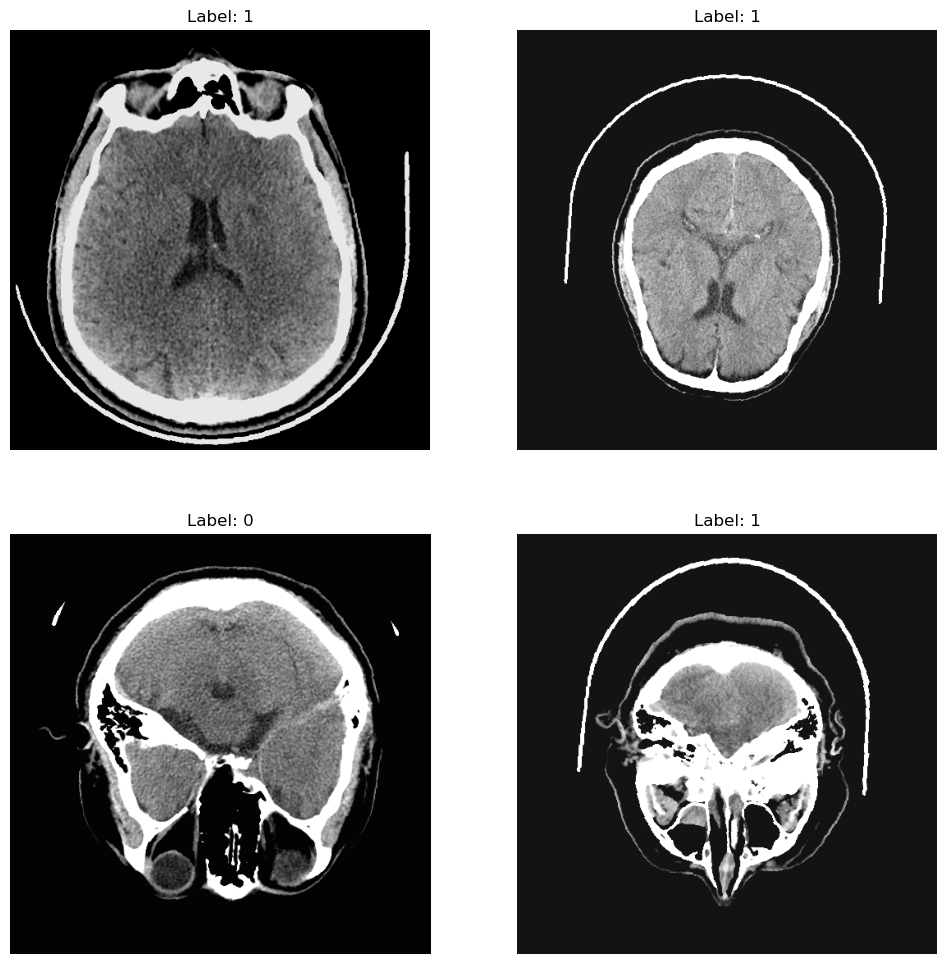

In [8]:
# Hücre 7: Dataset'den Birkaç Görüntüyü Görüntüleme (Örnek)
import matplotlib.pyplot as plt

def show_batch(dataset, num_images=4):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(2, 2, i+1)
            plt.imshow(images[i])
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.show()

show_batch(train_dataset)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtTiny, EfficientNetB2 , densenet
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# EfficientNetB4 modelini yükle
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Kendi sınıflandırma katmanlarını ekle
inputs = tf.keras.Input(shape=(512, 512, 3))
x = base_model(inputs, training=False)  # Fine-tuning için training=True kullan
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

# Aktivasyon fonksiyonu olarak LeakyReLU ve Dropout ile düzenleme
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Model özetini göster
model.summary()


ImportError: cannot import name 'dense50' from 'tensorflow.keras.applications' (c:\Users\akbas\anaconda3\envs\tf_gpu\lib\site-packages\keras\api\_v2\keras\applications\__init__.py)

In [ ]:
# Hücre 9: Modelin Derlenmesi


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

In [ ]:
# Hücre 10: Modelin Değerlendirilmesi
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Opsiyonel: Fine-tuning aşaması
# Base modelin bazı katmanlarını açarak (örneğin son blokları) yeniden eğitme
base_model.trainable = True
# Sadece üst katmanlardan başlayarak fine-tuning yapabilirsin:
for layer in base_model.layers[:-23]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1
)

# Yeniden test edelim
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Fine-tuned Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

In [ ]:
# Hücre 11: Modelin Son Değerlendirmesi ve Eğitim Sürecinin Görselleştirilmesi

# Eğitim ve doğrulama metriklerini görselleştirme
import matplotlib.pyplot as plt

# İlk eğitim ve fine-tuning süreçlerindeki metrikleri birleştiriyoruz
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(total_epochs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np

y_pred = []
y_true = []

for images, labels in test_dataset:
    # Modelin tahminleri (olasılık değerleri)
    preds = model.predict(images)
    
    # Tahminleri 0/1'e dönüştürmek için 0.5 eşik kullanıyoruz
    preds_binary = (preds > 0.5).astype(int).flatten()
    
    y_pred.extend(preds_binary)
    y_true.extend(labels.numpy().astype(int).flatten())

# F1 skoru
f1 = f1_score(y_true, y_pred)
print(f"Test F1 Skoru: {f1:.4f}")

# Doğruluk
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Doğruluk: {accuracy:.4f}")

# Kesinlik (Precision)
precision = precision_score(y_true, y_pred)
print(f"Test Kesinlik: {precision:.4f}")

# Duyarlılık (Recall)
recall = recall_score(y_true, y_pred)
print(f"Test Duyarlılık: {recall:.4f}")

# ROC AUC
roc_auc = roc_auc_score(y_true, preds)
print(f"Test ROC AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

In [ ]:


# tf.compat.v1.disable_eager_execution()
# model.save("stroke_detection_model")

In [ ]:
# loaded_model = tf.keras.models.load_model("stroke_detection_model")
# loaded_model.summary()
